<a href="https://colab.research.google.com/github/dani-jimlar/XAI_AIPI_590/blob/main/XAI_Assignment_5_explainable_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 5
Explainable techniques

Daniela Jiménez Lara

In [1]:
!pip install lime==0.2.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1047464ced80c4ffac33f25d088314af793cb83220db2bd9f11c291f2dfd148d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## Using Resnet34 to classify images and LIME to explain prediction

Resnet34 is a state-of-the-art image classification model, structured as a 34 layer convolutional neural network ([Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)). Its pre-trained on the ImageNet dataset containing 100,000+ images across 200 different classes.

We are using Resnet34 to predict the dog breed of a very special dog named Dingo:

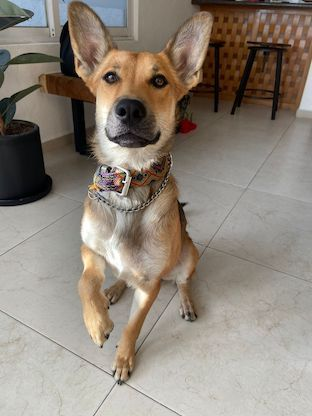

Then we are using LIME to explain this prediction.

## Prediction of image 1 of Dingo
Using the previous image of Dingo, the top prediction of the class tells us its breed is a **Kelpie**.



In [2]:
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from torchvision import models, transforms
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

model = models.resnet34(pretrained=True)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_path = '/content/drive/MyDrive/XAI_2/assign_5/dingo_2.jpeg'
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    output = model(input_tensor)

probas = torch.nn.functional.softmax(output[0], dim=0)

top5_prob, top5_catid = torch.topk(probas, 5)

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

top_prediction = imagenet_classes[top5_catid[0].item()]



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 28.5MB/s]



Top prediction: kelpie


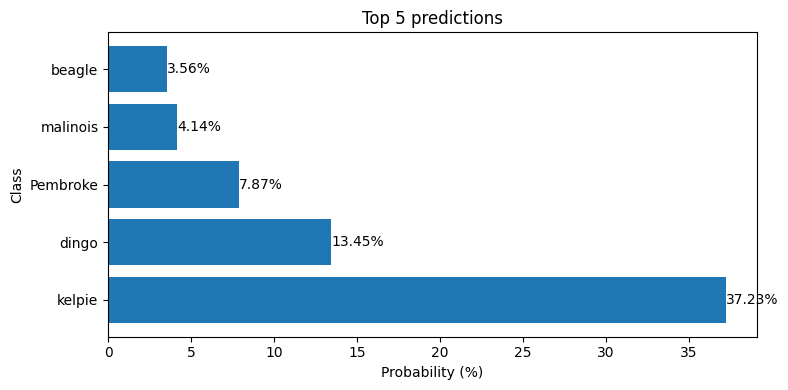

In [3]:
print(f"\nTop prediction: {top_prediction}")
plt.figure(figsize=(8, 4))
bars = plt.barh(range(5), top5_prob.numpy() * 100)
plt.yticks(range(5), [imagenet_classes[idx] for idx in top5_catid])
plt.xlabel('Probability (%)')
plt.ylabel('Class')
plt.title('Top 5 predictions')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
             ha='left', va='center')

plt.tight_layout()
plt.show()


In [4]:
def get_prediction(images):
    images = [Image.fromarray((img * 255).astype(np.uint8)) for img in images]
    batch = torch.stack(tuple(preprocess(i) for i in images), dim=0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)

    logits = model(batch)
    probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()



explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(image.resize((224, 224))),
                                         get_prediction,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)
def get_image_and_mask(explanation, label, positive_only=True, negative_only=False, hide_rest=False):
    temp, mask = explanation.get_image_and_mask(label, positive_only=positive_only,
                                                negative_only=negative_only, hide_rest=hide_rest)
    return mark_boundaries(temp / 255.0, mask)



  0%|          | 0/1000 [00:00<?, ?it/s]

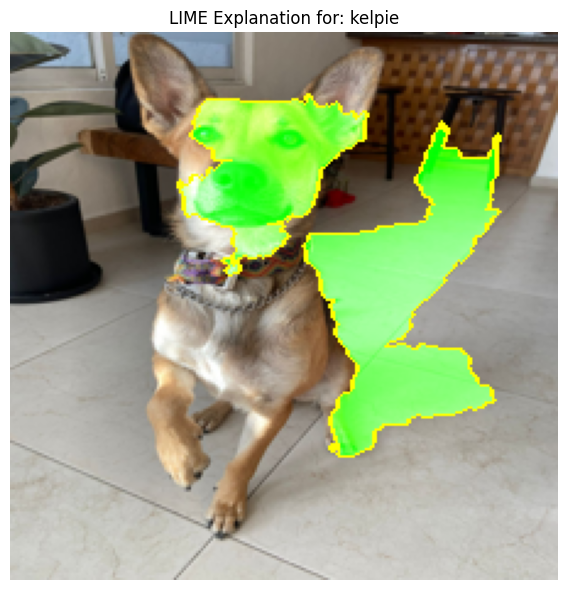

In [5]:


plt.figure(figsize=(6, 6))
plt.imshow(get_image_and_mask(explanation, top5_catid[0].item(), positive_only=False, hide_rest=False))
plt.title(f"LIME Explanation for: {top_prediction}")
plt.axis('off')
plt.tight_layout()
plt.show()



In this image, Dingo's face and the floor are highlighted in green, showing that these areas are what most affect the models predictions.The image tells us several things on how lime works with images.

*   Superpixels : LIME groups nearby pixels with same colors and groups them into areas
*   Superpixel perturbation: These areas are turned on or off
*   LIME sees how these superpixels affect the model's predictions.


## Prediction of image 2 of Dingo

However, if we use a different image of Dingo the prediction will vary and the top predicted class is now **German Shepard**.
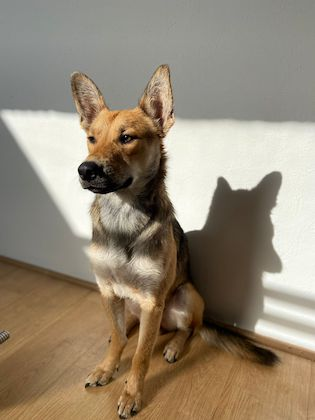

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Top prediction: German shepherd


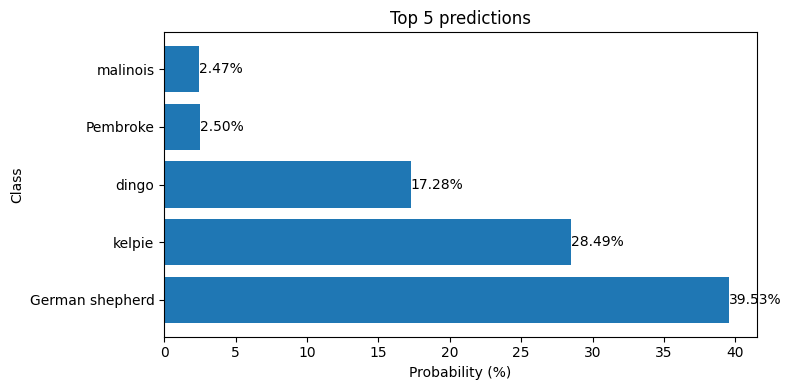

In [6]:
model = models.resnet34(pretrained=True)
model.eval()

image_path = '/content/drive/MyDrive/XAI_2/assign_5/dingo_3.jpeg'
image = Image.open(image_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

# get predictions
top5_prob, top5_catid = torch.topk(probabilities, 5)

imagenet_classes = models.ResNet34_Weights.IMAGENET1K_V1.meta["categories"]

top_prediction = imagenet_classes[top5_catid[0]]
print(f"\nTop prediction: {top_prediction}")

plt.figure(figsize=(8, 4))
bars = plt.barh(range(5), top5_prob.numpy() * 100)
plt.yticks(range(5), [imagenet_classes[idx] for idx in top5_catid])
plt.xlabel('Probability (%)')
plt.ylabel('Class')
plt.title('Top 5 predictions')

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}%',
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [7]:

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(image.resize((224, 224))),
                                         get_prediction,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)



  0%|          | 0/1000 [00:00<?, ?it/s]


Labels analyzed by LIME:
Class 285: Egyptian cat
Class 248: Eskimo dog
Class 250: Siberian husky
Class 282: tiger cat
Class 611: jigsaw puzzle

 Top prediction (German shepherd) not in LIME's analyzed labels.
Showing explanation for LIME's top label instead.


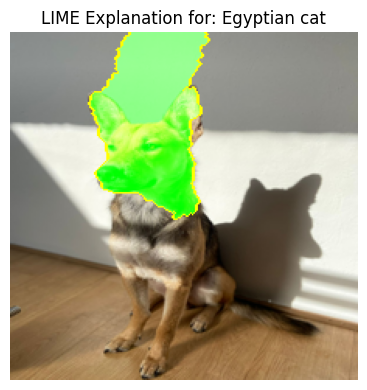

In [14]:
plt.figure(figsize=(4, 4))
lime_labels = explanation.top_labels

print("\nLabels analyzed by LIME:")


for label in lime_labels:
    print(f"Class {label}: {imagenet_classes[label]}")

if top5_catid[0].item() in lime_labels:
    plt.imshow(get_image_and_mask(explanation, top5_catid[0].item(), positive_only=False, hide_rest=False))
    plt.title(f"LIME Explanation for top prediction: {top_prediction}")
else:
    print(f"\n Top prediction ({top_prediction}) not in LIME's analyzed labels.")
    print("Showing explanation for LIME's top label instead.")
    plt.imshow(get_image_and_mask(explanation, lime_labels[0], positive_only=False, hide_rest=False))
    plt.title(f"LIME Explanation for: {imagenet_classes[lime_labels[0]]}")

plt.axis('off')
plt.tight_layout()
plt.show()

In this picture of Dingo, the higlighted green area are the superpixels that most affect the model's prediction.

However, the image lacks an explanaiton for the German Shepard Class. Since LIME perturbs the superpixels and uses them to see how they affect the models predictions, this time the superpixels most influential to the model did not predict the same class as the original data. This shows the model's sensitivity, where alterations to the data greatly affect it. It would be interesting to analyze the characterisitcs of the superpixel to see what features make it predict an Egyptian cat.

## Discussion

Local interpretable model-agnostic explanations (LIME) are great for black box models. Through a simple process of perturbing the original data to obtain new predictions, this new data can be used with an interpretable model to understand feature importance. Its aplication for black-box models for image classifications such as Resnet, is simple and gives an explanaiton to how certain areas of an image are most important in their prediction.

Lime explanaitions of Dingo's photos further explained the operabiltiy of the blackbox model,  as small perturbances of the images completly changed the predcitions. This showed not only LIME's ability to identify importance areas but showed the vulnerability of the model.


One of the advantages of LIME is how its outoput is easily interpretable, the result images show in a very straighforward way the important regions. However, the segmentation startegy for the superpixels is not evident in the exlaplanation and the same image can have different outputs in this regard.